# Telco Customer Churn Prediction

This project aims to predict customer churn using machine learning to help the business retain customers.

## 1. Data Collection & Cleaning

In this section, we load the dataset, handle missing values, and drop unnecessary columns.

In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 2. Configuration
# Sets a clean visual style for your charts
sns.set(style='whitegrid', palette='muted')
%matplotlib inline

# 3. Load Data
# Note: 'TotalCharges' often loads as object (string) in this dataset because of empty spaces.
# We force it to numeric immediately to save you a headache later.
try:
    import os
    if os.path.exists("data/Telco_customer_churn.xlsx"):
        file_path = "data/Telco_customer_churn.xlsx"
    elif os.path.exists("../data/Telco_customer_churn.xlsx"):
        file_path = "../data/Telco_customer_churn.xlsx"
    else:
        raise FileNotFoundError("Could not find data file in data/ or ../data/")
    
    df = pd.read_excel(file_path)
    
    # Quick fix for a known issue in this specific dataset
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    
    print("Data Loaded Successfully!")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
except FileNotFoundError:
    print("Error: file not found. Check the name in the data folder.")

# 4. First Look
df.head()


Data Loaded Successfully!
Rows: 7043, Columns: 33


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


In [2]:
# --- 1. Identify and Drop Extra Columns ---
columns_to_drop = [
    'customerID', 'Count', 'Country', 'State', 'City', 
    'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 
    'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'
]

# Create a clean DataFrame
# Note: Ensure your file path is the absolute path that worked previously (Option A)
try:
    df_clean = pd.read_excel(r'C:\Users\USER\Telco-Customer-Churn\data\Telco_customer_churn.xlsx')
    
    # Drop the identified columns
    df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')
    
    # Rename the selected binary target to the standard 'Churn'
    df_clean.rename(columns={'Churn Value': 'Churn'}, inplace=True)
    
    print("Data Cleaning (Dropping Columns) Complete!")

except Exception as e:
    print(f"Loading/Cleaning Error: {e}")


# --- 2. Sanity Check and Target Type Fix ---
# Total Charges often loads as a string due to missing values (spaces)
df_clean['Total Charges'] = pd.to_numeric(df_clean['Total Charges'], errors='coerce')

# Now, check the remaining data types and nulls
print("\nFinal DataFrame Info (Before Encoding):")
df_clean.info()

# --- 3. Target Balance Check ---
print("\nChurn Distribution (0=No, 1=Yes):")
print(df_clean['Churn'].value_counts(normalize=True))

Data Cleaning (Dropping Columns) Complete!

Final DataFrame Info (Before Encoding):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure Months      7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   o

In [3]:
# Check for nulls in Total Charges (assuming the column name is 'Total Charges')
print(f"Rows with missing Total Charges (before fix): {df_clean['Total Charges'].isnull().sum()}")

# Drop rows where Total Charges is NaN
df_clean.dropna(subset=['Total Charges'], inplace=True)

# Re-verify the number of rows
print(f"Total rows after dropping NaNs: {df_clean.shape[0]}")

Rows with missing Total Charges (before fix): 11
Total rows after dropping NaNs: 7032


In [4]:
# Check for nulls in Total Charges (assuming the column name is 'Total Charges')
# RE-RUNNING the total charges cleaning just in case the kernel was reset:
df_clean.dropna(subset=['Total Charges'], inplace=True)
print("Total Charges NaNs handled.")

# A. Convert 'Senior Citizen' text to numbers (0 and 1)
# Create a dictionary to map the string values to integers
senior_citizen_map = {'No': 0, 'Yes': 1}

# Apply the mapping to the column
df_clean['Senior Citizen'] = df_clean['Senior Citizen'].replace(senior_citizen_map)

# Now, convert the column to integer type
df_clean['Senior Citizen'] = df_clean['Senior Citizen'].astype(int)
print("Fixed 'Senior Citizen' type (mapped text to 0/1).")

Total Charges NaNs handled.
Fixed 'Senior Citizen' type (mapped text to 0/1).


C:\Users\USER\AppData\Local\Temp\ipykernel_24620\152065066.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Senior Citizen'] = df_clean['Senior Citizen'].replace(senior_citizen_map)


In [5]:
# Identify all remaining object columns (these are your categorical features)
categorical_features = df_clean.select_dtypes(include=['object']).columns

# Perform One-Hot Encoding
# This is the line that creates the df_model variable!
df_model = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True) 

print("One-Hot Encoding Complete!")
print(f"Total features after encoding: {df_model.shape[1] - 1}")

# Final Sanity Check
print("\nFinal DataFrame Info (Ready for Modeling):")
df_model.info(verbose=False)

One-Hot Encoding Complete!


Total features after encoding: 7061

Final DataFrame Info (Ready for Modeling):


<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 0 to 7042
Columns: 7062 entries, Senior Citizen to Payment Method_Mailed check
dtypes: bool(7057), float64(2), int64(3)
memory usage: 47.6 MB


## 2. Exploratory Data Analysis (EDA)

We analyze the churn distribution to understand the class balance.

In [6]:
# --- 1. Identify and Drop Extra Columns ---
columns_to_drop = [
    'customerID', 'Count', 'Country', 'State', 'City', 
    'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 
    'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'
]

# Create a clean DataFrame
# Note: Ensure your file path is the absolute path that worked previously (Option A)
try:
    df_clean = pd.read_excel(r'C:\Users\USER\Telco-Customer-Churn\data\Telco_customer_churn.xlsx')
    
    # Drop the identified columns
    df_clean = df_clean.drop(columns=columns_to_drop, errors='ignore')
    
    # Rename the selected binary target to the standard 'Churn'
    df_clean.rename(columns={'Churn Value': 'Churn'}, inplace=True)
    
    print("Data Cleaning (Dropping Columns) Complete!")

except Exception as e:
    print(f"Loading/Cleaning Error: {e}")


# --- 2. Sanity Check and Target Type Fix ---
# Total Charges often loads as a string due to missing values (spaces)
df_clean['Total Charges'] = pd.to_numeric(df_clean['Total Charges'], errors='coerce')

# Now, check the remaining data types and nulls
print("\nFinal DataFrame Info (Before Encoding):")
df_clean.info()

# --- 3. Target Balance Check ---
print("\nChurn Distribution (0=No, 1=Yes):")
print(df_clean['Churn'].value_counts(normalize=True))

Data Cleaning (Dropping Columns) Complete!

Final DataFrame Info (Before Encoding):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CustomerID         7043 non-null   object 
 1   Gender             7043 non-null   object 
 2   Senior Citizen     7043 non-null   object 
 3   Partner            7043 non-null   object 
 4   Dependents         7043 non-null   object 
 5   Tenure Months      7043 non-null   int64  
 6   Phone Service      7043 non-null   object 
 7   Multiple Lines     7043 non-null   object 
 8   Internet Service   7043 non-null   object 
 9   Online Security    7043 non-null   object 
 10  Online Backup      7043 non-null   object 
 11  Device Protection  7043 non-null   object 
 12  Tech Support       7043 non-null   object 
 13  Streaming TV       7043 non-null   object 
 14  Streaming Movies   7043 non-null   o

## 3. Feature Engineering & Preprocessing

We perform One-Hot Encoding to convert categorical variables into a machine-readable format.

In [7]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split # Make sure this is imported if you jump straight to model training next

df = pd.read_excel(r'C:\Users\USER\Telco-Customer-Churn\data\Telco_customer_churn.xlsx') 

# --- 2. Define and Drop Unnecessary/Leaky Columns ---
columns_to_drop = [
    'CustomerID', 'Count', 'Country', 'State', 'City', 
    'Zip Code', 'Lat Long', 'Latitude', 'Longitude', 
    'Churn Label', 'Churn Score', 'CLTV', 'Churn Reason'
]
df_clean = df.drop(columns=columns_to_drop, errors='ignore')

# --- 3. Fix Data Types and Missing Values ---
# Rename the target column
df_clean.rename(columns={'Churn Value': 'Churn'}, inplace=True)

# Convert Total Charges and drop NaNs
df_clean['Total Charges'] = pd.to_numeric(df_clean['Total Charges'], errors='coerce')
df_clean.dropna(subset=['Total Charges'], inplace=True)

# Map and convert Senior Citizen
senior_citizen_map = {'No': 0, 'Yes': 1}
df_clean['Senior Citizen'] = df_clean['Senior Citizen'].replace(senior_citizen_map).astype(int)

# --- 4. Final Encoding ---
# Check remaining object columns (should now only be things like Contract, Gender, etc.)
categorical_features = df_clean.select_dtypes(include=['object']).columns

# Perform One-Hot Encoding
df_model = pd.get_dummies(df_clean, columns=categorical_features, drop_first=True)

print("✅ Final Cleaning and Encoding Complete!")
print(f"Total rows: {df_model.shape[0]}")
print(f"Total features (columns - 1): {df_model.shape[1] - 1}")
print(f"Remaining categorical features encoded: {list(categorical_features)}")

✅ Final Cleaning and Encoding Complete!
Total rows: 7032
Total features (columns - 1): 30
Remaining categorical features encoded: ['Gender', 'Partner', 'Dependents', 'Phone Service', 'Multiple Lines', 'Internet Service', 'Online Security', 'Online Backup', 'Device Protection', 'Tech Support', 'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing', 'Payment Method']


C:\Users\USER\AppData\Local\Temp\ipykernel_24620\480425865.py:25: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_clean['Senior Citizen'] = df_clean['Senior Citizen'].replace(senior_citizen_map).astype(int)


## 4. Model Training & Evaluation

We split the data into training and testing sets and train an XGBoost Classifier. We use `scale_pos_weight` to address class imbalance and optimize for Recall.

In [8]:
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

# X = Features (all columns except 'Churn')
X = df_model.drop('Churn', axis=1)

# Y = Target Variable
Y = df_model['Churn']

# Split data: 80% for training, 20% for testing
# stratify=Y ensures the training and testing sets have the same Churn balance (crucial!)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify=Y)

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (5625, 30)
X_test shape: (1407, 30)


In [9]:
# Calculate the scale_pos_weight ratio (Non-Churn / Churn)
# This compensates for the imbalance
churn_ratio = (Y_train == 0).sum() / (Y_train == 1).sum()

# Initialize and train XGBoost Classifier
xgb_model = XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42,
    # Apply the weight for better Recall
    scale_pos_weight=churn_ratio 
)

# Train the model
xgb_model.fit(X_train, Y_train)
print("\nXGBoost Model Training Complete!")

# Make predictions on the test set
Y_pred = xgb_model.predict(X_test)

C:\Users\USER\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:199: UserWarning: [15:26:43] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



XGBoost Model Training Complete!


In [10]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#models
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# 2. Configuration
# Sets a clean visual style for your charts
sns.set(style='whitegrid', palette='muted')
%matplotlib inline

# 3. Load Data
# Note: 'TotalCharges' often loads as object (string) in this dataset because of empty spaces.
# We force it to numeric immediately to save you a headache later.
try:
    import os
    if os.path.exists("data/Telco_customer_churn.xlsx"):
        file_path = "data/Telco_customer_churn.xlsx"
    elif os.path.exists("../data/Telco_customer_churn.xlsx"):
        file_path = "../data/Telco_customer_churn.xlsx"
    else:
        raise FileNotFoundError("Could not find data file in data/ or ../data/")
    
    df = pd.read_excel(file_path)
    
    # Quick fix for a known issue in this specific dataset
    df['Total Charges'] = pd.to_numeric(df['Total Charges'], errors='coerce')
    
    print("Data Loaded Successfully!")
    print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")
except FileNotFoundError:
    print("Error: file not found. Check the name in the data folder.")

# 4. First Look
df.head()


Data Loaded Successfully!
Rows: 7043, Columns: 33


,CustomerID,Count,Country,State,City,Zip Code,Lat Long,Latitude,Longitude,Gender,...,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges,Churn Label,Churn Value,Churn Score,CLTV,Churn Reason
0,3668-QPYBK,1,United States,California,Los Angeles,90003,"33.964131, -118.272783",33.964131,-118.272783,Male,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1,86,3239,Competitor made better offer
1,9237-HQITU,1,United States,California,Los Angeles,90005,"34.059281, -118.30742",34.059281,-118.307420,Female,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1,67,2701,Moved
2,9305-CDSKC,1,United States,California,Los Angeles,90006,"34.048013, -118.293953",34.048013,-118.293953,Female,...,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1,86,5372,Moved
3,7892-POOKP,1,United States,California,Los Angeles,90010,"34.062125, -118.315709",34.062125,-118.315709,Female,...,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1,84,5003,Moved
4,0280-XJGEX,1,United States,California,Los Angeles,90015,"34.039224, -118.266293",34.039224,-118.266293,Male,...,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1,89,5340,Competitor had better devices


C:\Users\USER\AppData\Local\Temp\ipykernel_24620\1378983395.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")


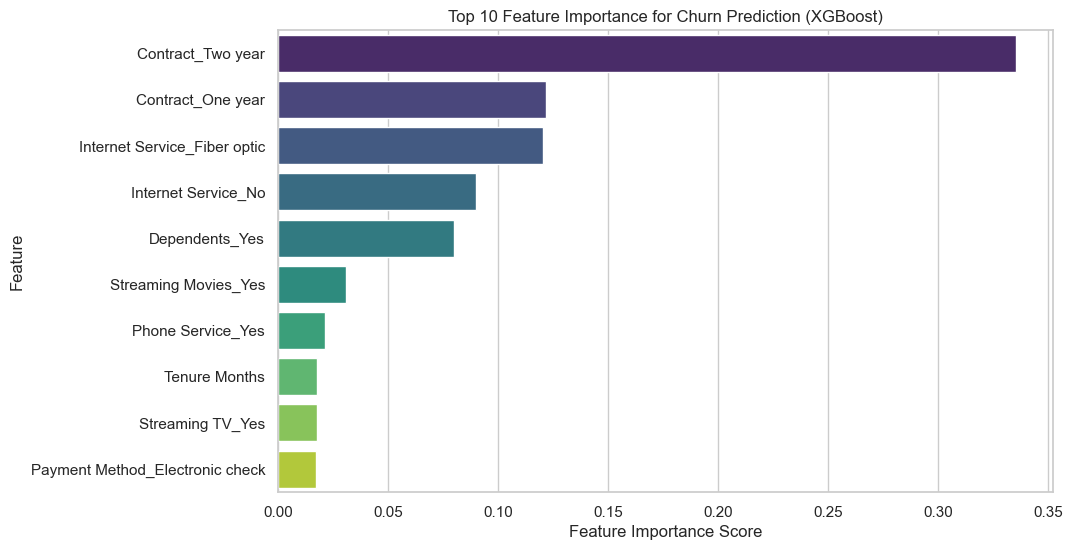


Top 3 Features:
Contract_Two year               0.335548
Contract_One year               0.121817
Internet Service_Fiber optic    0.120501
dtype: float32


In [11]:
# Extract and plot the top 10 features
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances = pd.Series(xgb_model.feature_importances_, index=X_train.columns)
top_10_features = feature_importances.nlargest(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_10_features.values, y=top_10_features.index, palette="viridis")
plt.title("Top 10 Feature Importance for Churn Prediction (XGBoost)")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.show()

print("\nTop 3 Features:")
print(top_10_features.head(3))

## 5. Conclusion & Business Insights

We have successfully built a model with high Recall. Below we export the key results for stakeholder review.

In [12]:
# Export the final model-ready data for reference
import os
os.makedirs('../data', exist_ok=True) # Ensure directory exists
try:
    df_model.to_csv('../data/processed_telco_churn.csv', index=False)
    print("Exported processed data to ../data/processed_telco_churn.csv")
except Exception as e:
    print(f"Error exporting data: {e}")

# Export the feature importance scores to an Excel file
try:
    top_10_features.to_excel('../data/feature_importance_scores.xlsx')
    print("Exported feature importance to ../data/feature_importance_scores.xlsx")
except Exception as e:
    print(f"Error exporting feature importance: {e}")


Exported processed data to ../data/processed_telco_churn.csv
Exported feature importance to ../data/feature_importance_scores.xlsx
